# Projet informatique 
Augustin Ador
Noémie Haouzi

In [1]:
# importation des packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt; plt.rcdefaults()
from sklearn import linear_model, datasets, metrics
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import operator

from sklearn.model_selection import GridSearchCV

from datetime import datetime
from fonctions_projet.operations import *

%matplotlib inline

/home/augustin/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
### Inputs
#Importation des tables
base = pd.read_csv('./tab2013_2014.csv', sep = ',')
#True si on veut utiliser la vraie base, False si on veut utiliser la base avec les simulations
vraie_base = True

In [3]:
base = filtre(base, vraie_base, 30)
# On met les id des hopitaux en string et non en int
base['id_hopital'] = base['id_hopital'].apply(str)
# On ne veut pas de NAs pour nos Y
base = base[np.isfinite(base['Attente_totale'])]
#On va garder seulement des variables qui ont un minimum de sens pour notre modèle
var_to_drop = ['TS_adm', 'TS_med', 'min_adm', 'annee_adm']
base = base.drop(var_to_drop, axis = 1 )
#On va changer les jours de la semaine en int (ce qui ne change rien pour des modèles basés sur des arbres mais évite d'avoir trop de dummies dans la matrice)
base['jour_semaine_adm'] = [Jour_semaine(jour_sem)  for jour_sem in base['jour_semaine_adm']]

In [4]:
# On recupere notre base X et Y
X = base.drop('Attente_totale', axis = 1)
Y = base['Attente_totale']
X = X.reindex_axis(sorted(X.columns), axis=1)
#OneHotEncoding pour le XGboost, permet de dummifier les variables categorielles
X_sparse = pd.get_dummies(X, dummy_na=True)

In [5]:
# On sépare notre base 'train' (celle où on a les labels à disposition) en trois différentes bases : 
# Train : 60pct
# Test 20 pct
# Validation 20 pct
X_train, X_inter, y_train, y_inter = train_test_split(X_sparse, Y, test_size=0.4, random_state=123)
X_test, X_validation, y_test, y_validation = train_test_split(X_inter, y_inter, test_size=0.5, random_state=42)

X_train_glm, X_inter_glm, y_train_glm, y_inter_glm = train_test_split(X, Y, test_size=0.4, random_state=123)
X_test_glm, X_validation_glm, y_test_glm, y_validation_glm = train_test_split(X_inter_glm, y_inter_glm, test_size=0.5, random_state=42)

In [6]:
# On cherche les parametres optimaux pour notre XGB en faisait un GridSearch sur 3 folds
# Peut prendre un peu de temps (environ 10 minutes si on teste beaucoup de paramètres on peut prendre par exemple : 

# gbm_params = {
#    'objective': ['reg:linear', 'reg:gamma'],
#    'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
#    'max_depth': [3, 4, 10],
#    'min_child_weight' : [1, 10, 20, 50]
#}

# Pour une meilleure fluidité du run, nous testerons ici seulement la profondeur max

gbm = xgb.XGBRegressor()
gbm_params = {
    'learning_rate': [0.2, 0.5],
}
grid = GridSearchCV(gbm, gbm_params,verbose=1,n_jobs=-1, scoring = 'neg_mean_absolute_error') # On va souhaiter minimiser la MAE par la suite
grid.fit(X_train, y_train)

print (grid.best_params_)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


[Parallel(n_jobs=-1)]: Done   6 out of   6 | elapsed:    6.5s finished


{'learning_rate': 0.2}


In [7]:
# On effectue notre XGBOOST avec une reg linear, eta = 0.1, min_child_weight = 1 et max depth = 4 car meilleurs valeurs d'après la CV d'avant
# On prend mae comme metric

params = {
    'objective': 'reg:linear',
    'min_child_weight': 1,
    'eta': 0.05,
    'max_depth': 4,
    'verbose_eval': True,
    'eval_metric':'mae', 
    'subsample' : 0.9,
    'colsample_bytree' : 0.9
}
xgtrain = xgb.DMatrix(X_train, label=y_train)
xgvalidation = xgb.DMatrix(X_validation, label=y_validation)
xgtest = xgb.DMatrix(X_test)
watchlist = [ (xgtrain,'train'), (xgvalidation,'validation')]
model = xgb.train(params, xgtrain, 1000, watchlist, early_stopping_rounds=50, verbose_eval =False)

y_train_xgb = model.predict(xgtrain)
y_test_xgb = model.predict(xgtest)
validation = model.predict(xgvalidation)

if (vraie_base == True):
    model.save_model('xgboost_hopital_real.model')
else: 
    model.save_model('xgboost_hopital_simul.model')

In [8]:
#Précision de notre modèle : 
print('MAPE :')
print(mape(y_test_xgb, y_test))
print('MAE :')
print(metrics.mean_absolute_error(y_test_xgb, y_test))

MAPE :
0.601495159142
MAE :
28.925399286


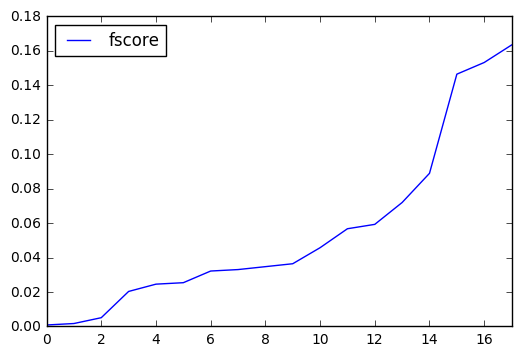

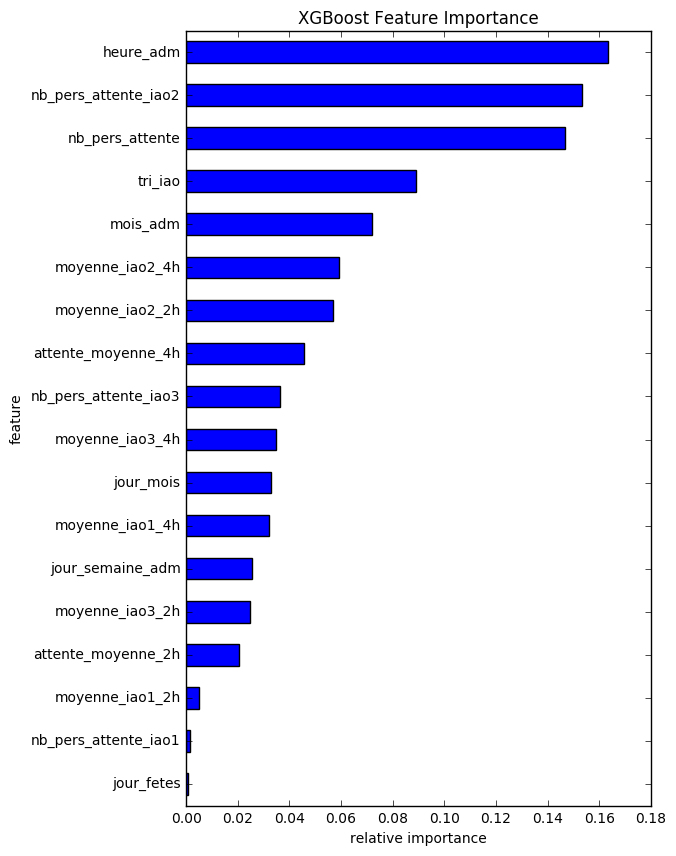

In [9]:
## On veut afficher l'importance des variables du XGboost
importance = model.get_fscore()
importance = sorted(importance.items(), key=operator.itemgetter(1))
df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()
plt.figure(facecolor="white")
df.iloc[-40:].plot()
df.iloc[-40:].plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [10]:
## Statistiques descriptives
y_test_xgb_df = pd.DataFrame(index=X_test.index, data=y_test_xgb)
y_train_xgb_df = pd.DataFrame(index=X_train.index, data=y_train_xgb)

print( 'pred test IAO 3 :')
print( np.mean(y_test_xgb_df[X_test['tri_iao'] == 3].values))

print( 'pred test IAO 2 :')
print( np.mean(y_test_xgb_df[X_test['tri_iao'] == 2].values))

print( 'real test IAO 3 :')
print( np.mean(y_test[X_test['tri_iao'] == 3]))

print( 'real test IAO 2 :')
print( np.mean(y_test[X_test['tri_iao'] == 2]))


print( '------ ')
print( '------ ')


print( 'pred train IAO 3 :')
print( np.mean(y_train_xgb_df[X_train['tri_iao'] == 3].values))

print( 'pred train IAO 2 :')
print( np.mean(y_train_xgb_df[X_train['tri_iao'] == 2].values))

print( 'real train IAO 3 :')
print( np.mean(y_train[X_train['tri_iao'] == 3]))

print( 'real train IAO 2 :')
print( np.mean(y_train[X_train['tri_iao'] == 2]))


pred test IAO 3 :
56.4803
pred test IAO 2 :
37.5439
real test IAO 3 :
58.3502600602
real test IAO 2 :
37.430475273
------ 
------ 
pred train IAO 3 :
56.7452
pred train IAO 2 :
37.7058
real train IAO 3 :
58.1340820536
real train IAO 2 :
37.8708149252


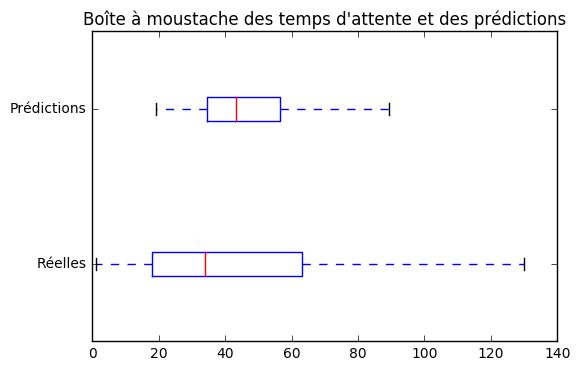

In [11]:
# Boîte à moustache des prédictions et des valeurs réelles
data_to_plot = [y_test, y_test_xgb]
plt.figure(facecolor="white")

# Création de la figure
fig = plt.figure(1, figsize=(9, 6))
plt.title("Boîte à moustache des temps d'attente et des prédictions")

# Création des axes
ax = fig.add_subplot(111)

# Création du boxplot
bp = ax.boxplot(data_to_plot, 0, '',0, labels = ['Réelles', 'Prédictions'])

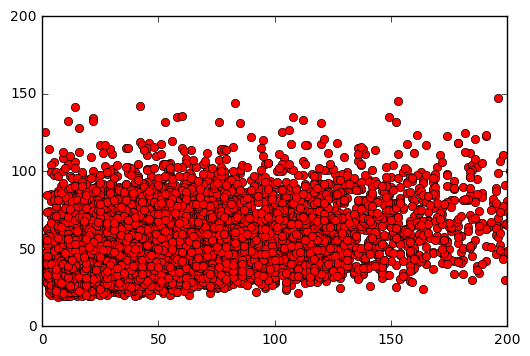

In [12]:
#Prediction vs réels
plt.figure(facecolor="white")
plt.plot(y_test, y_test_xgb, 'ro')
plt.axis([0, 200, 0, 200])
plt.show()

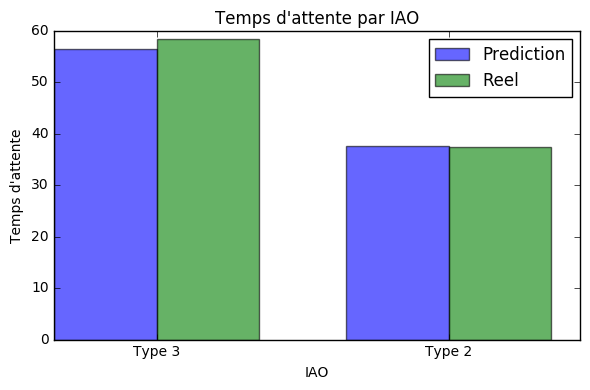

In [13]:
# On plot les prédictions par IAO
n_groups = 2
means_frank = (np.mean(y_test_xgb_df[X_test['tri_iao'] == 3].values), np.mean(y_test_xgb_df[X_test['tri_iao'] == 2].values))
means_guido = np.mean(y_test[X_test['tri_iao'] == 3]), np.mean(y_test[X_test['tri_iao'] == 2])
 
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.6
 
rects1 = plt.bar(index, means_frank, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Prediction')
 
rects2 = plt.bar(index + bar_width, means_guido, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Reel')


plt.xlabel('IAO')
plt.ylabel("Temps d'attente")
plt.title("Temps d'attente par IAO")
plt.xticks(index + bar_width, ('Type 3', 'Type 2'))
plt.legend()
 
plt.tight_layout()
plt.show()

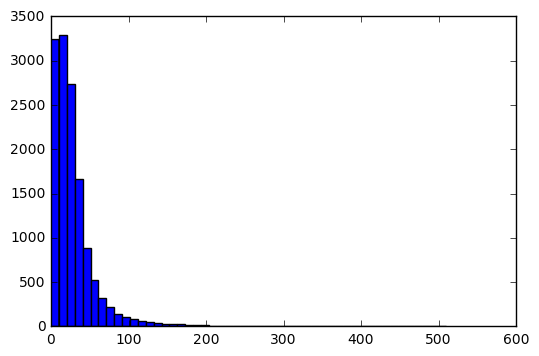

In [14]:
#Histogramme des erreurs
error = abs(y_test_xgb - y_test)
#error = error[error < 100] # Si l'on souhaite zoomer
plt.figure(facecolor="white")
np.histogram(error)
plt.hist(error, bins=50)
plt.show()

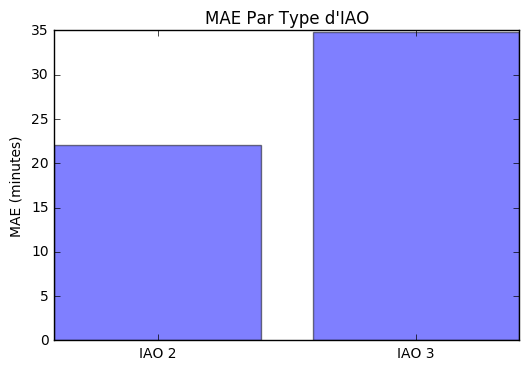

In [15]:
# Erreurs par type d'IAO
y_test_xgb_df = pd.DataFrame(index=X_test.index, data=y_test_xgb)
y_test_df = pd.DataFrame(index=X_test.index, data=y_test)

MAE_IAO3 = metrics.mean_absolute_error(y_test_xgb_df[X_test['tri_iao'] == 3], y_test[X_test['tri_iao'] == 3])
MAE_IAO2 = metrics.mean_absolute_error(y_test_xgb_df[X_test['tri_iao'] == 2], y_test[X_test['tri_iao'] == 2])

objects = ('IAO 2', 'IAO 3')
y_pos = np.arange(len(objects))
performance = [MAE_IAO2,MAE_IAO3]
plt.figure(facecolor="white")
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)

plt.ylabel('MAE (minutes)')
plt.title("MAE Par Type d'IAO")
 
plt.show()

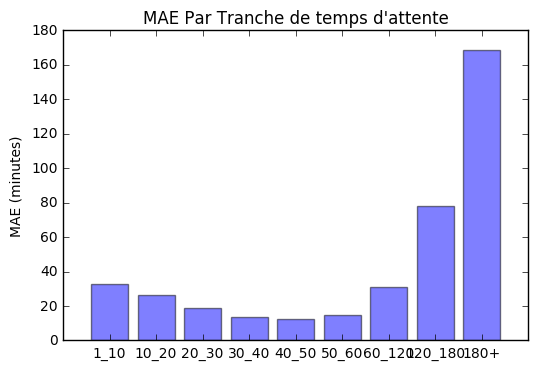

In [16]:
# Erreurs par tranche de vrais temps d'attente
y_test_xgb_df = pd.DataFrame(index=X_test.index, data=y_test_xgb)
y_test_df = pd.DataFrame(index=X_test.index, data=y_test)

index1_10 = np.array(y_test <10)
index10_20 = np.array((y_test >=10) & (y_test < 20))
index20_30 = np.array((y_test >=20) & (y_test < 30))
index30_40 = np.array((y_test >=30) & (y_test < 40))
index40_50 = np.array((y_test >=40) & (y_test < 50))
index50_60 = np.array((y_test >=50) & (y_test < 60))
index60_120 = np.array((y_test >=60) & (y_test < 120))
index120_180 = np.array((y_test >=120) & (y_test < 180))
index180_plus = np.array(y_test >=180)

MAE_1_10 = metrics.mean_absolute_error(y_test_xgb[(index1_10)], y_test[(index1_10)])
MAE_10_20 = metrics.mean_absolute_error(y_test_xgb[(index10_20)], y_test[(index10_20)])
MAE_20_30 = metrics.mean_absolute_error(y_test_xgb[(index20_30)], y_test[(index20_30)])
MAE_30_40 = metrics.mean_absolute_error(y_test_xgb[(index30_40)], y_test[(index30_40)])
MAE_40_50 = metrics.mean_absolute_error(y_test_xgb[(index40_50)], y_test[(index40_50)])
MAE_50_60 = metrics.mean_absolute_error(y_test_xgb[(index50_60)], y_test[(index50_60)])
MAE_60_120 = metrics.mean_absolute_error(y_test_xgb[(index60_120)], y_test[(index60_120)])
MAE_120_180 = metrics.mean_absolute_error(y_test_xgb[(index120_180)], y_test[(index120_180)])
MAE_180_plus = metrics.mean_absolute_error(y_test_xgb[(index180_plus)], y_test[(index180_plus)])
plt.figure(facecolor="white")

objects = ('1_10', '10_20', '20_30', '30_40', '40_50', '50_60', '60_120' , '120_180' ,'180+')
y_pos = np.arange(len(objects))
performance = [MAE_1_10, MAE_10_20, MAE_20_30, MAE_30_40, MAE_40_50, MAE_50_60, MAE_60_120, MAE_120_180, MAE_180_plus]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('MAE (minutes)')
plt.title("MAE Par Tranche de temps d'attente")

 
plt.show()

# Récupération de la base temps direct et prédictions

In [20]:
### Prédictions à l'aide d'un input donné et en se servant de la base 2017 (base temps direct)

#Inputs : 
base_2017 = pd.read_csv('./tab2017.csv', sep = ',')
var_input = '2017-04-25 10:20:28'
model_path = 'xgboost_hopital_simul.model'

if (vraie_base == True):
    nom_hopitaux = ['750100042']
else: 
    nom_hopitaux = ['920100013', '750100232', '750100042', '750100208', '750100125']

#Traitements : 
pred_heure_iao_2 = []
pred_heure_iao_3 = []
base_2017['id_hopital'] = base_2017['id_hopital'].apply(str)
input0 = Timestamp_to_df(var_input, base_2017, nom_hopitaux)

# Prédictions
prediction = pd.get_dummies(input0, dummy_na=True)
model = xgb.Booster()
model.load_model(model_path)
prediction = xgb.DMatrix(prediction)
prediction = model.predict(prediction)
prediction

array([ 29.02516747,  39.49829483], dtype=float32)

In [18]:
### Evolution de la prédiction pendant 10 heures pour un input donné
nom_hopitaux = ['750100042']
pred_heure_iao_2 = []
pred_heure_iao_3 = []
for heure in range (0, 10, 1):
    for minute in range(0, 6, 1):
        var_input = '2017-05-28 1' + str(heure) + ':' + str(minute) + '0:01'
        model_path = 'xgboost_hopital_real.model'
        base_2017['id_hopital'] = base_2017['id_hopital'].apply(str)
        input0 = Timestamp_to_df(var_input, base_2017, nom_hopitaux)
        prediction = pd.get_dummies(input0, dummy_na=True)
        model = xgb.Booster()
        model.load_model(model_path)
        prediction = xgb.DMatrix(prediction)
        prediction = model.predict(prediction)
        pred_heure_iao_2.append(prediction[0])
        pred_heure_iao_3.append(prediction[1]) 

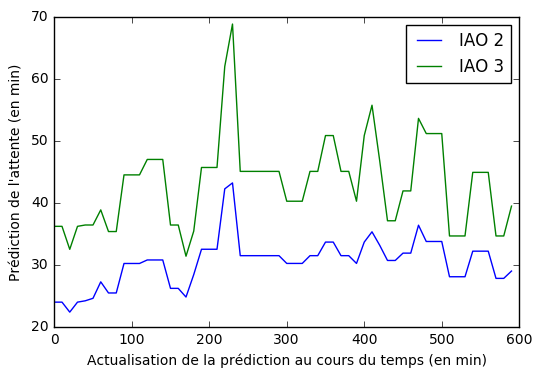

In [19]:
#Graphiques de l'évolution de la prédiction
IAO2_time, = plt.plot(np.r_[0:(10*len(pred_heure_iao_2)):10],pred_heure_iao_2, label = 'IAO 2')
IAO3_time, = plt.plot(np.r_[0:(10*len(pred_heure_iao_3)):10],pred_heure_iao_3, label = "IAO 3")

plt.legend(handles=[IAO2_time, IAO3_time])
plt.ylabel("Prédiction de l'attente (en min)")
plt.xlabel("Actualisation de la prédiction au cours du temps (en min)")